In [6]:
from dataloader import CircleDataset, CircleRaw
from model import FeatupExtra
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from polygon import RasLoss
from ModelInfer import ModelInfer

In [4]:
raw_set = CircleRaw()
data_set = CircleDataset()
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)

In [5]:
extra_encoder = nn.Sequential(
    nn.Conv2d(
        in_channels=384,
        out_channels=384,
        kernel_size=3,
        padding=1,
        stride=1,
    ),
    nn.ReLU(),
    nn.Conv2d(
        in_channels=384,
        out_channels=384,
        kernel_size=3,
        padding=1,
        stride=1,
    ),
    nn.ReLU(),
)
model = FeatupExtra(extra_encoder=extra_encoder).cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
model_infer = ModelInfer(raw_set)

In [8]:
model_infer.infer_model(model)

/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


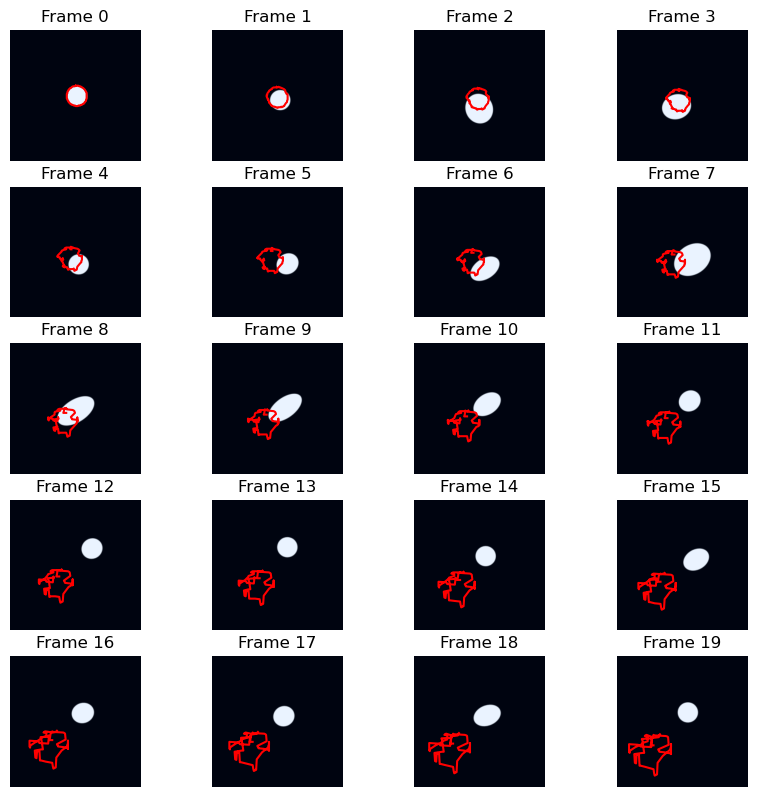

tensor(0.1594)

In [9]:
model_infer.show_infer_result(0)

In [11]:
extra_encoder = nn.Sequential(
    nn.Conv2d(
        in_channels=384,
        out_channels=384,
        kernel_size=3,
        padding=1,
        stride=1,
    ),
    nn.ReLU(),
    nn.Conv2d(
        in_channels=384,
        out_channels=384,
        kernel_size=3,
        padding=1,
        stride=1,
    ),
    nn.ReLU(),
)
model = FeatupExtra(extra_encoder=extra_encoder).cuda()
model_infer = ModelInfer(raw_set)
ras_loss = RasLoss()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
dict_loss = {}
dict_iou = {}
interval_epochs = 50
inter_num = 47
epoch_index = 0
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [13]:
for interval in range(inter_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for (
            pre_idx,
            fir_img,
            fir_sgm,
            fir_bou,
            pre_img,
            pre_sgm,
            pre_bou,
            cur_img,
            cur_sgm,
            cur_bou,
        ) in data_loader:
            pre_idx = pre_idx.item()
            pre_bou = model_infer.get_boundary(pre_idx)
            pre_bou = pre_bou.unsqueeze(0).cuda()
            optimizer.zero_grad()
            results = model(
                fir_img.cuda(),
                fir_bou.cuda(),
                pre_img.cuda(),
                cur_img.cuda(),
                pre_bou.cuda(),
            )
            refine_num = len(results)
            loss = 0
            for i in range(refine_num):
                loss += 0.8 ** (refine_num - i - 1) * ras_loss(
                    results[i], cur_sgm.cuda()
                )
            loss.backward()
            optimizer.step()
            mean_loss += loss.item()
        mean_loss /= len(data_loader)
        print(f"Epoch {epoch_index} Loss: {mean_loss}")
        dict_loss[epoch_index] = mean_loss
        epoch_index += 1
    model_infer.infer_model(model)
    total_iou = model_infer.get_infer_iou(0)
    dict_iou[epoch_index] = total_iou
    print(f"Epoch {epoch_index} IoU: {total_iou}")
    if interval_epochs > 20:
        interval_epochs -= 10

Epoch 0 Loss: 0.9828276571474577
Epoch 1 Loss: 0.9817961297537151
Epoch 2 Loss: 0.9626369162609703
Epoch 3 Loss: 0.942057971891604
Epoch 4 Loss: 0.9227035939693451
Epoch 5 Loss: 0.8655255201615786
Epoch 6 Loss: 0.8386993502315722
Epoch 7 Loss: 0.8398262309400659
Epoch 8 Loss: 0.7969325937722859
Epoch 9 Loss: 0.7647736245080045
Epoch 10 Loss: 0.7981803636801871
Epoch 11 Loss: 0.7685305444817794
Epoch 12 Loss: 0.8391198437464865
Epoch 13 Loss: 0.7177848063017193
Epoch 14 Loss: 0.653527844893305
Epoch 15 Loss: 0.6414851358062342
Epoch 16 Loss: 0.5897232874443656
Epoch 17 Loss: 0.5595660319453791
Epoch 18 Loss: 0.5815074584986034
Epoch 19 Loss: 0.5495097872458006
Epoch 20 Loss: 0.5736340770595952
Epoch 21 Loss: 0.529054172729191
Epoch 22 Loss: 0.5246072144884812
Epoch 23 Loss: 0.5326265222147891
Epoch 24 Loss: 0.6385214767957988
Epoch 25 Loss: 0.5411261351485002
Epoch 26 Loss: 0.5746253313202607
Epoch 27 Loss: 0.4597473160216683
Epoch 28 Loss: 0.4526511783662595
Epoch 29 Loss: 0.4710540347

KeyboardInterrupt: 